# Implementing RepVGG in PyTorch
## Make your cnn > 100x faster!


In [1]:
import torch
from torch import nn, Tensor
from torchvision.ops import Conv2dNormActivation
from typing import Dict, List

torch.manual_seed(0)


class ResNetBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.weight = nn.Sequential(
            Conv2dNormActivation(
                in_channels, out_channels, kernel_size=3, stride=stride
            ),
            Conv2dNormActivation(
                out_channels, out_channels, kernel_size=3, activation_layer=None
            ),
        )
        self.shortcut = (
            Conv2dNormActivation(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=stride,
                activation_layer=None,
            )
            if in_channels != out_channels
            else nn.Identity()
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.shortcut(x)  # <- 2x memory
        x = self.weight(x)
        x += res
        x = self.act(x)  # <- 1x memory
        return x


存储`residual`双倍内存消耗。 论文中的下图也显示了这一点



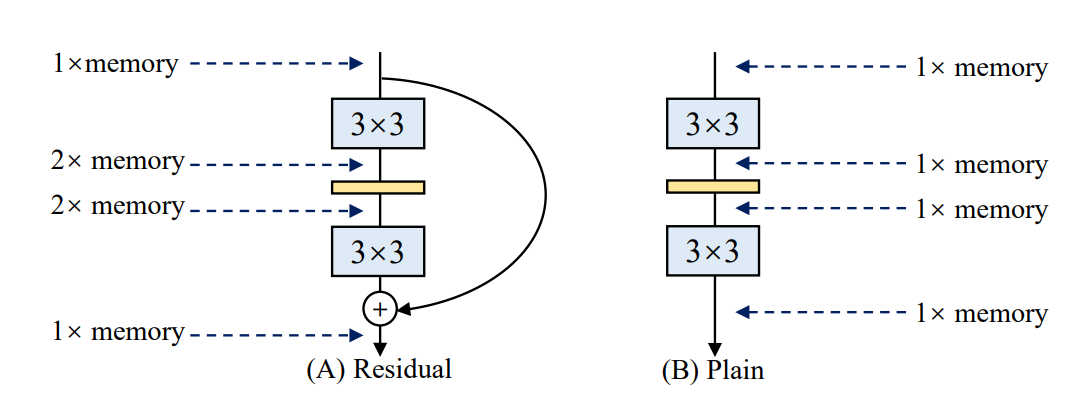

### 从多分支到单分支
与单分支模型相比，多分支模型消耗更多内存并且速度更慢。 让我们创建一个经典的“ResNetBlock”来看看为什么。 

考虑以下情况，您有两个由两个“3x3”卷积组成的分支

In [2]:
class TwoBranches(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        return x1 + x2

In [3]:
two_branches = TwoBranches(8, 8)

x = torch.randn((1, 8, 7, 7))

two_branches(x).shape

torch.Size([1, 8, 5, 5])

现在，我们可以创建一个卷积，我们将其称为“conv_fused”，即“conv_fused(x) = conv1(x) + conv2(x)”。 实现conv_fused(x)很容易，我们可以将两个卷积的“权重”和“偏差”相加！ 因此我们只需要运行一个“conv”而不是两个。

In [4]:
conv1 = two_branches.conv1
conv2 = two_branches.conv2

conv_fused = nn.Conv2d(conv1.in_channels, conv1.out_channels, kernel_size=conv1.kernel_size)

conv_fused.weight = nn.Parameter(conv1.weight + conv2.weight)
conv_fused.bias =  nn.Parameter(conv1.bias + conv2.bias)

# check they give the same output
assert torch.allclose(two_branches(x), conv_fused(x), atol=1e-5)

让我们看看它能快多少！

In [5]:
from time import perf_counter

two_branches.to("cuda")
conv_fused.to("cuda")

with torch.no_grad():
    x = torch.randn((4, 8, 7, 7), device=torch.device("cuda"))
    
    start = perf_counter()
    two_branches(x)
    print(f"conv1(x) + conv2(x) tooks {perf_counter() - start:.6f}s")
    
    start = perf_counter()
    conv_fused(x)
    print(f"conv_fused(x) tooks {perf_counter() - start:.6f}s")


conv1(x) + conv2(x) tooks 0.182160s
conv_fused(x) tooks 0.000163s


经过上述实验，我们有了一个目标，尽可能将网络中的多分支结构融合成一个分支，来提升模型的计算速度

### 融合 Conv 和 BatchNorm

在现代网络架构中，“BatchNorm”被用作卷积块之后的正则化层。 我们可能想将它们融合在一起，因此创建一个卷积，使得“conv_fused(x) = batchnorm(conv(x))”。 具体原理详解论文，或下述的文字和图片解释。


代码如下：

In [6]:
def get_fused_bn_to_conv_state_dict( conv: nn.Conv2d, bn: nn.BatchNorm2d ):
    # in the paper, weights is gamma and bias is beta
    bn_mean, bn_var, bn_gamma, bn_beta = (
        bn.running_mean,
        bn.running_var,
        bn.weight,
        bn.bias,
    )
    # we need the std!
    bn_std = (bn_var + bn.eps).sqrt() 
    conv_weight = nn.Parameter((bn_gamma / bn_std).reshape(-1, 1, 1, 1) * conv.weight) 
    conv_bias = nn.Parameter(bn_beta - bn_mean * bn_gamma / bn_std)
    return {"weight": conv_weight, "bias": conv_bias}

bn_std = (bn_var + bn.eps).sqrt() 这行代码计算批量归一化层的标准差。批量归一化在训练期间会计算每个特征的均值（bn_mean）和方差（bn_var）。在推理时，这些运行期间统计量用于归一化。bn.eps 是为了数值稳定性而添加的一个很小的常数，避免除以零的情况。

conv_weight = nn.Parameter((bn_gamma / bn_std).reshape(-1, 1, 1, 1) * conv.weight)这行代码使用批量归一化层的gamma（缩放因子）和计算出的标准差bn_std来调整卷积层的权重。首先，bn_gamma / bn_std 计算了缩放因子，然后通过reshape(-1, 1, 1, 1)调整形状以匹配卷积权重的四维格式（输出通道、输入通道、高度、宽度）。这个缩放因子乘以原始的卷积权重conv.weight，实现了权重的调整。这里的调整是按照批量归一化的缩放参数对卷积层的权重进行缩放，以融合BN层的效果到卷积层中。

conv_bias = nn.Parameter(bn_beta - bn_mean * bn_gamma / bn_std)这行代码计算融合后的卷积层偏置。批量归一化的beta（偏移量）减去bn_mean（均值）乘以gamma（缩放因子）再除以bn_std（标准差）。这个计算反映了批量归一化在归一化过程中的偏移调整（即减去均值，乘以gamma，加上beta），直接应用于卷积层的偏置上，使得在执行卷积操作时已经包含了批量归一化的效果。

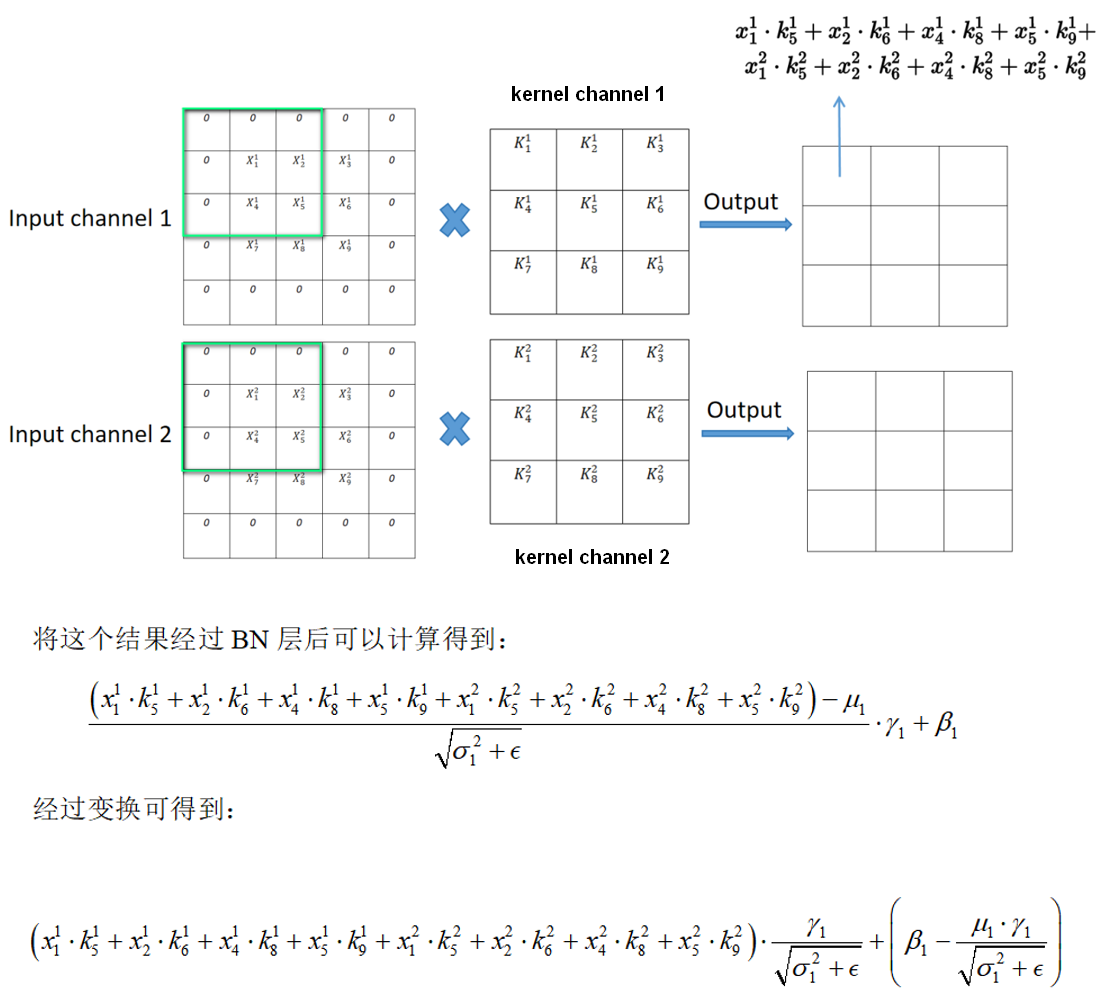

实际使用一下

In [7]:
conv_bn = nn.Sequential(
    nn.Conv2d(8, 8, kernel_size=3, bias=False),
    nn.BatchNorm2d(8)
)

torch.nn.init.uniform_(conv_bn[1].weight)
torch.nn.init.uniform_(conv_bn[1].bias)

with torch.no_grad():
    # be sure to switch to eval mode!!
    conv_bn = conv_bn.eval()
    conv_fused = nn.Conv2d(conv_bn[0].in_channels, 
                           conv_bn[0].out_channels, 
                           kernel_size=conv_bn[0].kernel_size)

    conv_fused.load_state_dict(get_fused_bn_to_conv_state_dict(conv_bn[0], conv_bn[1]))

    x = torch.randn((1, 8, 7, 7))
    
    assert torch.allclose(conv_bn(x), conv_fused(x), atol=1e-5)

from time import perf_counter

conv_bn .to("cuda")
conv_fused.to("cuda")

with torch.no_grad():
    x = torch.randn((4, 8, 7, 7), device=torch.device("cuda"))
    
    start = perf_counter()
    conv_bn (x)
    print(f"conv_bn  tooks {perf_counter() - start:.6f}s")
    
    start = perf_counter()
    conv_fused(x)
    print(f"conv_fused(x) tooks {perf_counter() - start:.6f}s")


conv_bn  tooks 0.005524s
conv_fused(x) tooks 0.000177s


所以我们的另一个目标是融合网络中的卷积操作和归一化操作

作者提出了一种新型区块，称为“RepVGG”。 与 ResNet 类似，它有一个残差连接，不同的是，它多了一个恒等连接（或更好的分支）。

In [17]:
class RepVGGBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.block = Conv2dNormActivation(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            bias=False,
            stride=stride,
            activation_layer=None,
            # the original model may also have groups > 1
        )

        self.shortcut = Conv2dNormActivation(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=stride,
            activation_layer=None,
        )

        self.identity = (
            nn.BatchNorm2d(out_channels) if in_channels == out_channels else None
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = x  # <- 2x memory
        x = self.block(x)
        x += self.shortcut(res)
        if self.identity:
            x += self.identity(res)
        x = self.relu(x)  # <- 1x memory
        return x

#### 重新参数化

我们有一个“3x3”“conv->bn”、一个“1x1”“conv-bn”和（有时）一个“batchnorm”（恒等分支）。 我们希望将它们融合在一起以创建一个单一的“conv_fused”，使得“conv_fused”=“3x3conv-bn(x) + 1x1conv-bn(x) + bn(x)”，或者如果我们没有恒等连接， `conv_fused` = `3x3conv-bn(x) + 1x1conv-bn(x)`。

让我们一步一步来。 要创建“conv_fused”，我们必须：
- 将 `3x3conv-bn(x)` 融合为一个 `3x3conv`
- `1x1conv-bn(x)`，然后将其转换为`3x3conv`
- 将`恒等映射`转换为`3x3conv`
- 相加所有三个`3x3conv`

第一步很简单，我们可以在“RepVGGBlock.block”（主要的“3x3 conv-bn”）上使用“get_fused_bn_to_conv_state_dict”。

第二步类似，“RepVGGBlock.shortcut”（“1x1 conv-bn”）上使用“get_fused_bn_to_conv_state_dict”。 在使用之前，我们需要在每个维度上将“1x1”的每个内核的上下左右各填充“1”，创建成“3x3”的内核。

至于“bn”。 我们需要创建一个 3x3 的 conv 来充当恒等函数，然后使用 get_fused_bn_to_conv_state_dict 将其与 bn 融合。 这可以通过在相应通道的相应内核的中心设置“1”来完成。


例如：

In [12]:
with torch.no_grad():
    x = torch.randn((1,2,3,3))
    identity_conv = nn.Conv2d(2,2,kernel_size=3, padding=1, bias=False)
    identity_conv.weight.zero_() 

    in_channels = identity_conv.in_channels
    """
    通过对 i 进行 %in_channels 运算,可以确保结果始终在0到in_channels-1的范围内,这对于索引数组或张量时保持索引有效非常有用。

    具体来说：
    当i从0开始递增时, i % in_channels的结果会从0递增到in_channels-1, 然后再次回到0,形成一个循环。
    这意味着不管i的值是多少, i % in_channels都会产生一个位于0到in_channels-1范围内的值, 保证了访问的是存在的通道索引。
    """
    for i in range(in_channels):
        identity_conv.weight[i, i % in_channels, 1, 1] = 1

    print(identity_conv.weight)
    
    out = identity_conv(x)
    assert torch.allclose(x, out)



Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]], requires_grad=True)


上述代码中，我们创建了一个类似于恒等函数的“Conv”。

现在，将所有内容放在一起，此步骤正式称为**重新参数化**

In [8]:
def get_fused_conv_state_dict_from_block(block ):
    # 将块中的第一个卷积层和第一个批量归一化层融合成一个新的卷积层的状态字典。
    fused_block_conv_state_dict = get_fused_bn_to_conv_state_dict( block.block[0], block.block[1] )

    # 检查是否存在快捷连接（shortcut）。如果存在，它将快捷连接的卷积层和批量归一化层也进行融合，并对1x1卷积的权重进行填充，将其扩展到3x3的大小，然后将融合后的权重和偏置添加到之前融合的卷积层的状态字典中。
    if block.shortcut:
        # fuse the 1x1 shortcut
        conv_1x1_state_dict = get_fused_bn_to_conv_state_dict( block.shortcut[0], block.shortcut[1] )
        # we pad the 1x1 to a 3x3
        conv_1x1_state_dict["weight"] = torch.nn.functional.pad( conv_1x1_state_dict["weight"], [1, 1, 1, 1] )
        fused_block_conv_state_dict["weight"] += conv_1x1_state_dict["weight"]
        fused_block_conv_state_dict["bias"] += conv_1x1_state_dict["bias"]

    # 如果存在identity连接，代码创建了一个恒等卷积层（identify_conv），这个卷积层的权重初始化为0，除了每个通道的中心位置被设置为1，模仿恒等映射。然后，它将这个恒等卷积层与block.identity（一个批量归一化层）进行融合，并将结果添加到融合的状态字典中。
    if block.identity:
        # create our identity 3x3 conv kernel
        identify_conv = nn.Conv2d(
            block.block[0].in_channels,
            block.block[0].in_channels,
            kernel_size=3,
            bias=True,
            padding=1,
        ).to(block.block[0].weight.device)
        # set them to zero!
        identify_conv.weight.zero_()
        # set the middle element to zero for the right channel
        in_channels = identify_conv.in_channels
        for i in range(identify_conv.in_channels):
            identify_conv.weight[i, i % in_channels, 1, 1] = 1
        # fuse the 3x3 identity
        identity_state_dict = get_fused_bn_to_conv_state_dict( identify_conv, block.identity )
        fused_block_conv_state_dict["weight"] += identity_state_dict["weight"]
        fused_block_conv_state_dict["bias"] += identity_state_dict["bias"]

    fused_conv_state_dict = {
        k: nn.Parameter(v) for k, v in fused_block_conv_state_dict.items()
    }

    return fused_conv_state_dict

最后，让我们定义一个“RepVGGFastBlock”。 它仅由 `conv + relu` 组成 🤩

In [15]:
class RepVGGFastBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.relu = nn.ReLU(inplace=True)

向“RepVGGBlock”添加“to_fast”方法，以快速创建正确的“RepVGGFastBlock”

In [16]:
class RepVGGBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.block = Conv2dNormActivation(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            bias=False,
            stride=stride,
            activation_layer=None,
            # the original model may also have groups > 1
        )

        self.shortcut = Conv2dNormActivation(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=stride,
            activation_layer=None,
        )

        self.identity = (
            nn.BatchNorm2d(out_channels) if in_channels == out_channels else None
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = x  # <- 2x memory
        x = self.block(x)
        x += self.shortcut(res)
        if self.identity:
            x += self.identity(res)
        x = self.relu(x)  # <- 1x memory
        return x

    def to_fast(self) -> RepVGGFastBlock:
        fused_conv_state_dict = get_fused_conv_state_dict_from_block(self)
        fast_block = RepVGGFastBlock(
            self.block[0].in_channels,
            self.block[0].out_channels,
            stride=self.block[0].stride,
        )

        fast_block.conv.load_state_dict(fused_conv_state_dict)

        return fast_block

### RepVGG
 

In [17]:
"""
RepVGGStage 类定义
RepVGGStage是nn.Sequential的一个子类,代表RepVGG网络中的一个阶段,这个阶段包含了多个RepVGGBlock。

__init__方法接收输入通道数in_channels,输出通道数out_channels,以及该阶段包含的RepVGGBlock的数量depth。
在初始化时,第一个RepVGGBlock的步长被设置为2,以减少特征图的空间尺寸并增加输出通道的数量,其余的RepVGGBlock保持默认的步长1。这样的设计旨在第一个块执行下采样,而剩余的块则在新的尺寸上继续处理特征。
通过列表推导式*[RepVGGBlock(out_channels, out_channels) for _ in range(depth - 1)],添加depth-1个RepVGGBlock到该阶段,这些块的输入和输出通道数相同，不进行下采样。
"""

class RepVGGStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        depth: int,
    ):
        super().__init__(
            RepVGGBlock(in_channels, out_channels, stride=2),
            *[RepVGGBlock(out_channels, out_channels) for _ in range(depth - 1)],
        )

"""
RepVGG 类定义
RepVGG也是nn.Sequential的一个子类,代表整个RepVGG网络。

__init__方法接收一个通道宽度列表widths和一个深度列表depths,以及初始输入通道数in_channels(默认为3,对应RGB图像)。
in_out_channels = zip(widths, widths[1:])创建了一个元组列表，每个元组包含了一对相邻阶段的输入和输出通道数。
第一个阶段RepVGGStage(in_channels, widths[0], depth=1)专门处理初始输入,随后通过一个循环创建更多的阶段,每个阶段的配置由in_out_channels和depths列表提供。
分类头(classification head)被简化省略,这意味着这段代码主要关注于网络的特征提取部分。
"""

class RepVGG(nn.Sequential):
    def __init__(self, widths: List[int], depths: List[int], in_channels: int = 3):
        super().__init__()
        in_out_channels = zip(widths, widths[1:])

        self.stages = nn.Sequential(
            RepVGGStage(in_channels, widths[0], depth=1),
            *[
                RepVGGStage(in_channels, out_channels, depth)
                for (in_channels, out_channels), depth in zip(in_out_channels, depths)
            ],
        )

        # omit classification head for simplicity

    """
    switch_to_fast 方法
    switch_to_fast方法遍历RepVGG网络中的所有阶段和阶段内的所有块, 将每个RepVGGBlock转换为其快速版本RepVGGFastBlock。

    通过枚举stage中的block, 使用block.to_fast()方法获取快速版本的块。
    然后用这个快速版本的块替换原来的块，实现整个网络的加速。
    """
    def switch_to_fast(self):
        for stage in self.stages:
            for i, block in enumerate(stage):
                stage[i] = block.to_fast()
        return self